In [1]:
import os
import numpy as np
import glob
import time
import PIL.Image as Image
from tqdm.notebook import tqdm
from itertools import chain
from collections import OrderedDict
import random

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import ipywidgets
from IPython import display

In [2]:
import shutil, sys 
shutil.move("./horse2zebra/trainA", "./horses_train/A")
shutil.move("./horse2zebra/trainB", "./zebra_train/B")
shutil.move("./horse2zebra/testA", "./horses_test/A")
shutil.move("./horse2zebra/testB", "./zebra_test/B")

FileNotFoundError: [Errno 2] No such file or directory: './horse2zebra/trainA'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
bs = 1
workers = 0
image_size = (256, 256)
dataroot = './horses_train/'
dataset_horses_train = dset.ImageFolder(root = dataroot, transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1)),
]))

torch.Size([1, 3, 256, 256])


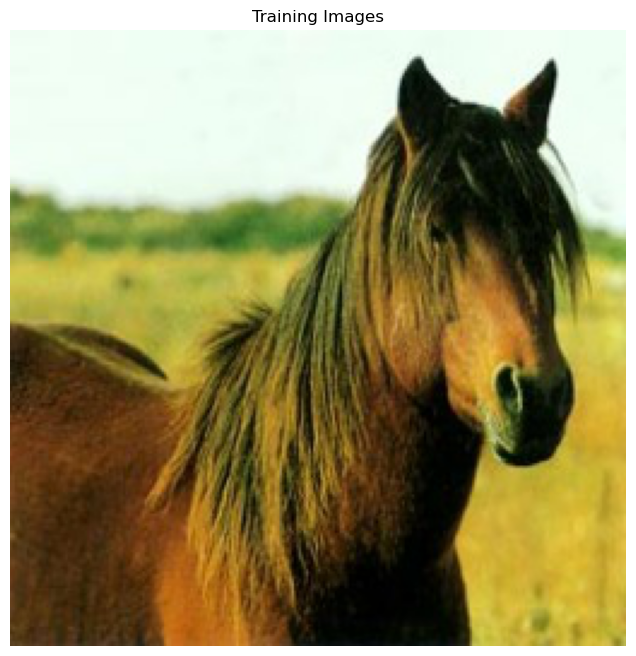

In [4]:
dataloader_train_horses = torch.utils.data.DataLoader(dataset_horses_train, batch_size = bs, shuffle = True, num_workers = workers)
real_batch = next(iter(dataloader_train_horses))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], 
                             padding=2, normalize=True).cpu(),(1,2,0)))

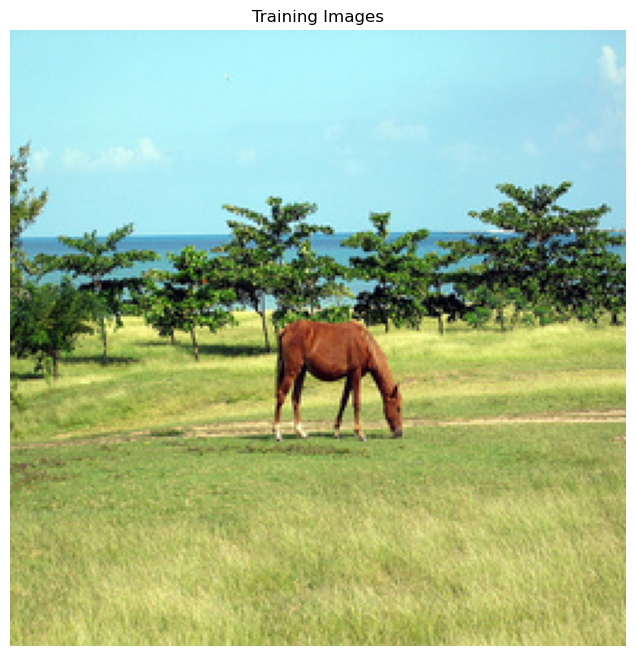

In [5]:
dataroot = './horses_test/'
dataset_horses_test = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_test_horses = torch.utils.data.DataLoader(dataset_horses_test, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_test_horses))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))


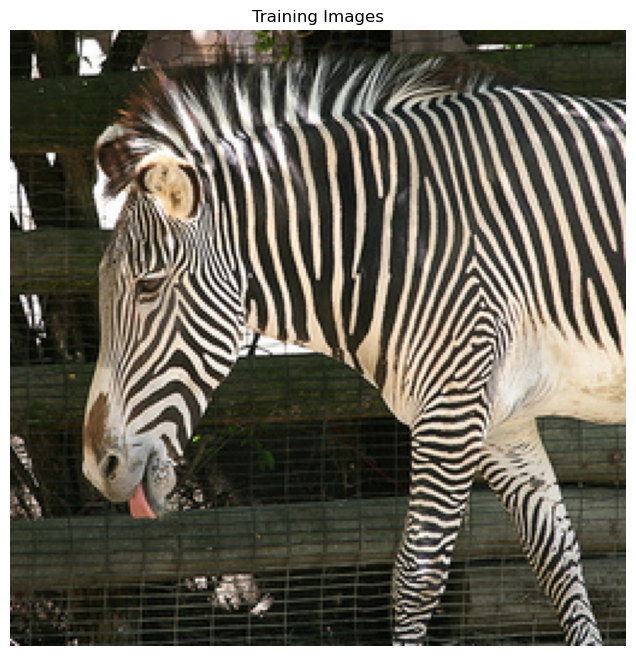

In [6]:
dataroot = './zebra_train'
dataset_zebra_train = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_zebra_train = torch.utils.data.DataLoader(dataset_zebra_train, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_zebra_train))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))


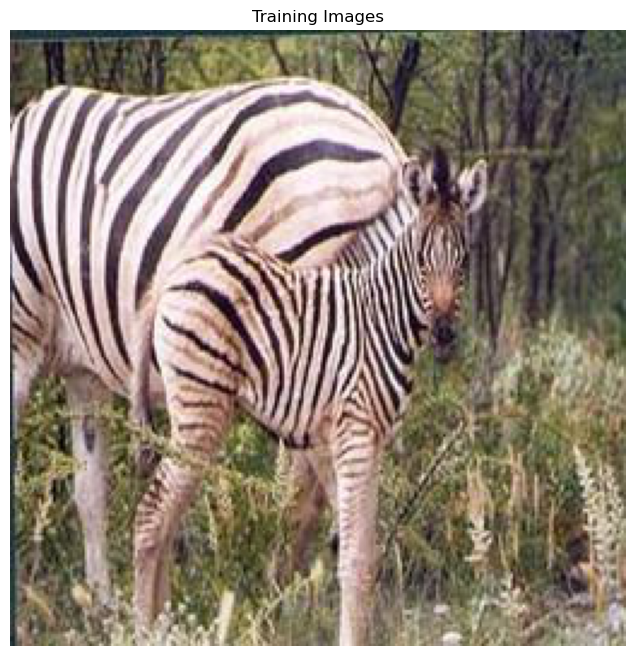

In [7]:
dataroot = './zebra_test'
dataset_zebra_test = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_zebra_test = torch.utils.data.DataLoader(dataset_zebra_test, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_zebra_test))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))


In [8]:
def plot_images_test(dataloader_test_horses, dataloader_zebra_test):
    batch_a_test = next(iter(dataloader_test_horses))[0].to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test ).cpu().detach()
    plt.figure(figsize = (10, 10))
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:4] + 1) / 2, padding = 2, normalize = True).cpu(), (1, 2, 0)))
    plt.axis("off")
    plt.title("Real horses")
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:4]+1)/2, 
                         padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake zebras")
    plt.show()

    batch_b_test = next(iter(dataloader_zebra_test))[0].to(device)
    real_b_test = batch_b_test.cpu().detach()
    
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:4]+1)/2, 
                         padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real zebras")
    plt.show()

    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:4]+1)/2, 
                         padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake horses")
    plt.show()

In [9]:
def plot_all_images(image_number, dataloader_test_horses, dataloader_zebra_test):
    batch_a_test = next(iter(dataloader_test_horses))[0].to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test).cpu().detach()
    plt.figure(figsize = (10, 10))
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real horses")
    plt.show()
    plt.figure(figsize = (10, 10))
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake zebras")
    plt.show()
    
    batch_b_test = next(iter(dataloader_zebra_test))[0].to(device)
    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real zebras")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake horses")
    plt.show()
    
    identity_a_test = G_B2A(batch_a_test.cuda() ).cpu().detach()
    identity_b_test = G_A2B(batch_b_test.cuda() ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((identity_a_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Identity horses")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((identity_b_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Identity zebras")
    plt.show()
    
    recover_a_test = G_B2A(fake_b_test.cuda()  ).cpu().detach()
    recover_b_test=G_A2B(fake_a_test.cuda()  ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((recover_a_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Recovered horses")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((recover_b_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Recovered zebras")
    plt.show()

In [10]:
def save_models(G_A2B, G_B2A, D_A, D_B, name):
    torch.save(G_A2B, './model_proj3/' + name + '_G_A2B.pt')
    torch.save(G_B2A, './model_proj3/' + name + '_G_B2A.pt')
    torch.save(D_A, './model_proj3/' + name + '_D_A.pt')
    torch.save(D_B, './model_proj3/' + name + '_D_B.pt')

In [11]:
def load_models(name):
    G_A2B = torch.load('./model_proj3/' + name + '_G_A2B.pt')
    G_B2A = torch.load('./model_proj3/' + name + '_G_B2A.pt')
    D_A = torch.load('./model_proj3/' + name + '_D_A.pt')
    D_B = torch.load('./model_proj3/' + name + '_D_B.pt')
    return G_A2B, G_B2A, D_A, D_B

In [12]:
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                      nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x) + x))

In [13]:
class Generator(nn.Module):
    def __init__(self, f = 64, blocks = 9):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                 nn.Conv2d(3, f, 7, 1, 0), norm_layer(f), nn.ReLU(True),
                 nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                 nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4 * f))
        layers.extend([
            nn.ConvTranspose2d(4 * f, 4 * 2 * f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2 * f), nn.ReLU(True),
            nn.ConvTranspose2d(2 * f, 4 * f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(f), nn.ReLU(True),
            nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0), nn.Tanh()
        ])
        self.conv = nn.Sequential(*layers)
    def forward(self, x):
        return self.conv(x)

In [14]:
nc = 3
ndf = 64
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
        nn.Conv2d(nc, ndf, 4, 2, 1, bias = False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf,ndf*2,4,2,1, bias=False),
        nn.InstanceNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf*4,ndf*8,4,1,1),
        nn.InstanceNorm2d(ndf*8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf*8,1,4,1,1)   
        )
    def forward(self, input):
        return self.main(input)

In [15]:
def LSGAN_D(real, fake):
    return (torch.mean((real - 1) ** 2) + torch.mean(fake ** 2))
def LSGAN_G(fake):
    return torch.mean((fake - 1) ** 2)

In [16]:
import itertools
G_A2B = Generator().to(device)
G_B2A = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)
criterion_Im = torch.nn.L1Loss()
lr = 0.0002
optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

In [27]:
def training(G_A2B, G_B2A, D_A, D_B, num_epochs, name, old = True):
    img_list = []
    G_losses = []
    D_A_losses = []
    D_B_losses = []
    
    iters = 0
    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_A = []
    disc_B = []
    
    FDL_A2B_t = []
    FDL_B2A_t = []
    CL_A_t = []
    CL_B_t = []
    ID_B2A_t = []
    ID_A2B_t = []
    disc_A_t = []
    disc_B_t = []
    print("Starting Training Loop...")
    
    for epoch in range(num_epochs):
        for i, (data_horse, data_zebra) in enumerate(zip(dataloader_train_horses, dataloader_zebra_train), 0):
            a_real = data_horse[0].to(device)
            b_real = data_zebra[0].to(device)
            
            tensor_ones = torch.ones([a_real.shape[0], 1, 14, 14]).cuda()
            torch_zeros = torch.zeros([a_real.shape[0], 1, 14, 14]).cuda()
            
            b_fake = G_A2B(a_real)
            a_rec = G_B2A(b_fake)
            a_fake = G_B2A(b_real)
            b_rec = G_A2B(a_fake)
            
            optimizer_D_A.zero_grad()
            if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
                rand_int = random.randint(1, old_a_fake.shape[0] - 1)
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-5:rand_int].detach()))
                D_A_losses.append(Disc_loss_A.item())
            else:
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
                D_A_losses.append(Disc_loss_A.item())
        
            Disc_loss_A.backward()
            optimizer_D_A.step()
            
            optimizer_D_B.zero_grad()
            if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
                rand_int = random.randint(1, old_b_fake.shape[0]-1)
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-5:rand_int].detach()))
                D_B_losses.append(Disc_loss_B.item())
            else:
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
                D_B_losses.append(Disc_loss_B.item())

            Disc_loss_B.backward()
            optimizer_D_B.step() 
            
            optimizer_G_A2B.zero_grad()
            optimizer_G_B2A.zero_grad()
            
            Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
            Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))
            
            Cycle_loss_A = criterion_Im(a_rec, a_real)*5
            Cycle_loss_B = criterion_Im(b_rec, b_real)*5
            
            
            Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
            Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10
            
            Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
            G_losses.append(Loss_G)
            
            Loss_G.backward()
            
            optimizer_G_A2B.step()
            optimizer_G_B2A.step()
            
            FDL_A2B.append(Fool_disc_loss_A2B)
            FDL_B2A.append(Fool_disc_loss_B2A)
            CL_A.append(Cycle_loss_A)
            CL_B.append(Cycle_loss_B)
            ID_B2A.append(Id_loss_B2A)
            ID_A2B.append(Id_loss_A2B)
            disc_A.append(Disc_loss_A)
            disc_B.append(Disc_loss_B)
            
            if(iters == 0 and epoch == 0):
                old_b_fake = b_fake.clone()
                old_a_fake = a_fake.clone()
                
            elif (old_b_fake.shape[0] == bs*5 and b_fake.shape[0]==bs):
                rand_int = random.randint(1, 24)
                old_b_fake[rand_int-1:rand_int] = b_fake.clone()
                old_a_fake[rand_int-1:rand_int] = a_fake.clone()
            elif(old_b_fake.shape[0]< 25):
                old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
                old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

            iters += 1
            del data_zebra, data_horse, a_real, b_real, a_fake, b_fake
            
            if iters % 50 == 0:
                print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                      % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                          Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
        
    FDL_A2B_t.append(sum(FDL_A2B)/len(FDL_A2B))
    FDL_B2A_t.append(sum(FDL_B2A)/len(FDL_B2A))
    CL_A_t.append(sum(CL_A)/len(CL_A))
    CL_B_t.append(sum(CL_B)/len(CL_B))
    ID_B2A_t.append(sum(ID_B2A)/len(ID_B2A))
    ID_A2B_t.append(sum(ID_A2B)/len(ID_A2B))
    disc_A_t.append(sum(disc_A)/len(disc_A))
    disc_B_t.append(sum(disc_B)/len(disc_B))

    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_B = []
    disc_A = []

    iters = 0             
    save_models(G_A2B, G_B2A, D_A, D_B, name)
    if (epoch % 5 == 0):
        plot_images_test(dataloader_test_horses, dataloader_zebra_test)
    #plot_all_images(4, dataloader_test_horses, dataloader_zebra_test)
    return(FDL_A2B_t,FDL_B2A_t,CL_A_t,CL_B_t,ID_B2A_t,ID_A2B_t,disc_A_t,disc_B_t)
         

In [28]:
name = 'basic_training50'
epochs=20
losses = training(G_A2B, G_B2A, D_A, D_B, epochs, name)

Starting Training Loop...
[1/20]	FDL_A2B: 0.2593	FDL_B2A: 0.2913	CL_A: 0.5604	CL_B: 0.9511	ID_B2A: 0.9937	ID_A2B: 1.5334	Loss_D_A: 0.5207	Loss_D_A: 0.5800
[1/20]	FDL_A2B: 0.1807	FDL_B2A: 0.2005	CL_A: 0.5963	CL_B: 1.3410	ID_B2A: 1.0385	ID_A2B: 2.5546	Loss_D_A: nan	Loss_D_A: nan
[1/20]	FDL_A2B: 0.3481	FDL_B2A: 0.3792	CL_A: 0.5182	CL_B: 0.6028	ID_B2A: 0.9372	ID_A2B: 1.0898	Loss_D_A: 0.5242	Loss_D_A: 0.6177
[1/20]	FDL_A2B: 0.3019	FDL_B2A: 0.3267	CL_A: 0.5120	CL_B: 0.9677	ID_B2A: 1.0655	ID_A2B: 1.5922	Loss_D_A: 0.6254	Loss_D_A: 0.3083
[1/20]	FDL_A2B: 0.1665	FDL_B2A: 0.2010	CL_A: 0.5783	CL_B: 0.9610	ID_B2A: 1.1955	ID_A2B: 1.9143	Loss_D_A: nan	Loss_D_A: nan
[1/20]	FDL_A2B: 0.4057	FDL_B2A: 0.4181	CL_A: 0.8933	CL_B: 0.9617	ID_B2A: 1.8272	ID_A2B: 1.8120	Loss_D_A: 0.5619	Loss_D_A: 0.7257
[1/20]	FDL_A2B: 0.4351	FDL_B2A: 0.3397	CL_A: 0.6546	CL_B: 0.7766	ID_B2A: 1.2569	ID_A2B: 1.5385	Loss_D_A: 0.4503	Loss_D_A: 0.9234
[1/20]	FDL_A2B: 0.1882	FDL_B2A: 0.0980	CL_A: 0.9821	CL_B: 0.4844	ID_B2A: 2.1295	ID_

[4/20]	FDL_A2B: 0.5030	FDL_B2A: 0.6811	CL_A: 0.5403	CL_B: 0.5894	ID_B2A: 1.0456	ID_A2B: 1.0778	Loss_D_A: 0.1900	Loss_D_A: 0.2588
[4/20]	FDL_A2B: 0.4825	FDL_B2A: 0.1749	CL_A: 0.6460	CL_B: 0.8420	ID_B2A: 1.6859	ID_A2B: 1.2485	Loss_D_A: 0.6195	Loss_D_A: 0.2887
[4/20]	FDL_A2B: 0.5498	FDL_B2A: 0.2647	CL_A: 0.4796	CL_B: 1.1878	ID_B2A: 1.1384	ID_A2B: 2.2486	Loss_D_A: nan	Loss_D_A: nan
[4/20]	FDL_A2B: 0.8527	FDL_B2A: 0.4411	CL_A: 0.5464	CL_B: 0.8502	ID_B2A: 1.2861	ID_A2B: 1.5050	Loss_D_A: 0.7356	Loss_D_A: 0.1676
[4/20]	FDL_A2B: 0.4144	FDL_B2A: 0.4087	CL_A: 0.5764	CL_B: 0.6781	ID_B2A: 1.0433	ID_A2B: 1.0378	Loss_D_A: 0.3044	Loss_D_A: 0.2866
[4/20]	FDL_A2B: 0.4103	FDL_B2A: 0.3640	CL_A: 0.5294	CL_B: 0.6827	ID_B2A: 1.0998	ID_A2B: 1.2844	Loss_D_A: nan	Loss_D_A: nan
[4/20]	FDL_A2B: 0.3484	FDL_B2A: 0.4702	CL_A: 0.5348	CL_B: 0.5516	ID_B2A: 0.9099	ID_A2B: 1.0569	Loss_D_A: 0.3716	Loss_D_A: 0.4267
[4/20]	FDL_A2B: 0.3958	FDL_B2A: 0.2943	CL_A: 0.5564	CL_B: 0.6696	ID_B2A: 0.9228	ID_A2B: 1.0286	Loss_D_A: 0.57

[7/20]	FDL_A2B: 0.5903	FDL_B2A: 0.7182	CL_A: 0.6373	CL_B: 1.0272	ID_B2A: 1.4792	ID_A2B: 1.4095	Loss_D_A: nan	Loss_D_A: nan
[7/20]	FDL_A2B: 0.4320	FDL_B2A: 0.3903	CL_A: 0.6771	CL_B: 0.5485	ID_B2A: 1.1616	ID_A2B: 0.9050	Loss_D_A: 0.5966	Loss_D_A: 0.4130
[7/20]	FDL_A2B: 0.4305	FDL_B2A: 0.3321	CL_A: 1.0762	CL_B: 0.6565	ID_B2A: 2.0740	ID_A2B: 1.1283	Loss_D_A: 0.4372	Loss_D_A: 0.2931
[7/20]	FDL_A2B: 0.3086	FDL_B2A: 0.6192	CL_A: 0.8867	CL_B: 0.7081	ID_B2A: 1.6587	ID_A2B: 1.1892	Loss_D_A: nan	Loss_D_A: nan
[7/20]	FDL_A2B: 0.6365	FDL_B2A: 0.4167	CL_A: 0.4856	CL_B: 0.6548	ID_B2A: 0.8802	ID_A2B: 1.2767	Loss_D_A: 0.3047	Loss_D_A: 0.4170
[7/20]	FDL_A2B: 0.5036	FDL_B2A: 0.4234	CL_A: 0.5096	CL_B: 0.5883	ID_B2A: 1.1201	ID_A2B: 0.9383	Loss_D_A: 0.2679	Loss_D_A: 0.2928
[7/20]	FDL_A2B: 0.3480	FDL_B2A: 0.2357	CL_A: 0.6653	CL_B: 0.8576	ID_B2A: 1.0468	ID_A2B: 1.3360	Loss_D_A: nan	Loss_D_A: nan
[7/20]	FDL_A2B: 0.3830	FDL_B2A: 0.6513	CL_A: 0.6380	CL_B: 0.5753	ID_B2A: 1.2769	ID_A2B: 1.0534	Loss_D_A: 0.5244	Los

[10/20]	FDL_A2B: 0.6979	FDL_B2A: 0.3236	CL_A: 0.7526	CL_B: 0.8710	ID_B2A: 1.3193	ID_A2B: 1.8072	Loss_D_A: 0.4546	Loss_D_A: 0.2383
[10/20]	FDL_A2B: 0.3804	FDL_B2A: 0.0959	CL_A: 0.8114	CL_B: 0.6961	ID_B2A: 1.0323	ID_A2B: 1.4947	Loss_D_A: nan	Loss_D_A: nan
[10/20]	FDL_A2B: 1.1653	FDL_B2A: 0.3817	CL_A: 0.5401	CL_B: 0.8281	ID_B2A: 0.9870	ID_A2B: 1.4718	Loss_D_A: 0.4612	Loss_D_A: 0.0963
[10/20]	FDL_A2B: 0.5540	FDL_B2A: 0.4423	CL_A: 0.7078	CL_B: 1.0829	ID_B2A: 1.1264	ID_A2B: 2.0311	Loss_D_A: 0.3994	Loss_D_A: 0.2523
[10/20]	FDL_A2B: 0.0657	FDL_B2A: 0.4491	CL_A: 0.7517	CL_B: 1.1435	ID_B2A: 1.3699	ID_A2B: 2.2492	Loss_D_A: nan	Loss_D_A: nan
[10/20]	FDL_A2B: 0.4178	FDL_B2A: 0.3368	CL_A: 0.6093	CL_B: 0.7480	ID_B2A: 0.9597	ID_A2B: 1.4606	Loss_D_A: 0.3749	Loss_D_A: 0.7131
[10/20]	FDL_A2B: 0.4911	FDL_B2A: 0.3912	CL_A: 1.0521	CL_B: 0.4939	ID_B2A: 1.5504	ID_A2B: 0.9627	Loss_D_A: 0.4435	Loss_D_A: 0.3907
[10/20]	FDL_A2B: 0.5627	FDL_B2A: 0.7011	CL_A: 0.4933	CL_B: 1.2507	ID_B2A: 1.0013	ID_A2B: 1.9063	Loss_D

[13/20]	FDL_A2B: 0.5172	FDL_B2A: 0.3952	CL_A: 0.8300	CL_B: 1.0606	ID_B2A: 1.4162	ID_A2B: 1.6393	Loss_D_A: nan	Loss_D_A: nan
[13/20]	FDL_A2B: 0.7213	FDL_B2A: 0.4852	CL_A: 0.7378	CL_B: 0.7035	ID_B2A: 1.1665	ID_A2B: 1.1933	Loss_D_A: 0.4266	Loss_D_A: 0.3327
[13/20]	FDL_A2B: 0.7961	FDL_B2A: 0.6998	CL_A: 0.6434	CL_B: 0.6317	ID_B2A: 1.3676	ID_A2B: 1.0412	Loss_D_A: 0.1010	Loss_D_A: 0.1240
[13/20]	FDL_A2B: 0.4440	FDL_B2A: 0.6786	CL_A: 0.6323	CL_B: 0.6767	ID_B2A: 0.8468	ID_A2B: 1.2206	Loss_D_A: nan	Loss_D_A: nan
[13/20]	FDL_A2B: 0.7541	FDL_B2A: 0.6934	CL_A: 0.6114	CL_B: 1.0936	ID_B2A: 0.7277	ID_A2B: 2.0138	Loss_D_A: 0.2579	Loss_D_A: 0.2980
[13/20]	FDL_A2B: 0.6974	FDL_B2A: 0.6534	CL_A: 0.8144	CL_B: 0.7855	ID_B2A: 1.6816	ID_A2B: 1.3585	Loss_D_A: 0.4202	Loss_D_A: 0.1216
[13/20]	FDL_A2B: 0.3821	FDL_B2A: 0.2420	CL_A: 0.5756	CL_B: 0.5542	ID_B2A: 1.2783	ID_A2B: 0.9774	Loss_D_A: nan	Loss_D_A: nan
[13/20]	FDL_A2B: 0.4731	FDL_B2A: 0.7093	CL_A: 0.5283	CL_B: 0.6915	ID_B2A: 0.9808	ID_A2B: 1.3859	Loss_D_A: 0.

KeyboardInterrupt: 

In [29]:
if not os.path.exists('./CycleGAN'):
    os.makedirs('./CycleGAN')
# save last check pointing
torch.save(G_A2B.state_dict(), f"./CycleGAN/netG_A2B.pth")
torch.save(G_B2A.state_dict(), f"./CycleGAN/netG_B2A.pth")
torch.save(D_A.state_dict(), f"./CycleGAN/netD_A.pth")
torch.save(D_B.state_dict(), f"./CycleGAN/netD_B.pth")